In [704]:
import pandas as pd
#import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
import itertools
import statsmodels.api as sm 
import matplotlib
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

%matplotlib inline

selng=pd.read_csv("./Desktop/데이터분석/SELNG.csv", delimiter='|', engine='python')
cnfm_prmisn=pd.read_csv("./Desktop/데이터분석/CNFM_PRMISN.csv", delimiter='|',encoding='cp949')
rent_curprc=pd.read_csv("./Desktop/데이터분석/RENT_CURPRC.csv", delimiter='|')
blck_flpop=pd.read_csv("./Desktop/데이터분석/BLCK_FLPOP.csv", delimiter='|')
blck_dim=pd.read_csv("./Desktop/데이터분석/BLCK_DIM.csv", delimiter='|',encoding='cp949')
#파일 불러오기

In [705]:
cnfm_prmisn.drop(['STOR_NM','SVC_INDUTY_CD','OLD_ADRES','NW_ADRES','TELNO','PROC_CLSS','ROAD_CD','XCNTS_VALUE','YDNTS_VALUE'],axis='columns', inplace=True)
rent_curprc.drop(['STDR_QU_CD','RENT_FLOOR_CD'],axis='columns', inplace=True)
#분석할때 필요없는 데이터 정리, blck_flpop,selng 테이블은 좀 더 정리 필요

In [706]:
rent_curprc_con=(rent_curprc['CNVRSN_RNTCHRG']!=0)
#값이 '0'으로 존재하는 데이터의 경우를 제외


In [707]:
#BLCK_CD 기준으로 테이블 합쳐서 정렬(독립변수)->매출액을 기준으로(종속변수) 다중회귀분석 =>매출액 결정 요인의 분석
#시계열 분석 통해서 매출액 결정 요인/매출액 변화되는 양상 추정->예측=>K-군집분석으로 입지 유형의 분류
#입지선정

In [710]:
data_1=blck_flpop[blck_flpop['BLCK_CD'].isin(selng['BLCK_CD'].values)]
#blck_cd가 겹치는 경우의 코드를 따로 추출
data_2=blck_dim[blck_dim['ADSTRD_CD'].isin(rent_curprc['ADSTRD_CD'].values)]
data_3=rent_curprc.set_index('ADSTRD_CD').join(data_2.set_index('ADSTRD_CD'), how='outer').reset_index()

#ADSTRD_CD와 BLCK_CD연결해서 RENT_CURPRC 수정
data_5=selng.set_index('BLCK_CD').join(data_1.set_index('BLCK_CD'), how='outer').reset_index()#코드 합치기
data_6=data_5.set_index('BLCK_CD').join(data_3.set_index('BLCK_CD'), how='outer').reset_index()#최종 코드 합치기
data_6.sort_values(by=['BLCK_CD','STDR_YM_CD'],axis=0,inplace=True)
data_6['TA_YM']=pd.to_datetime(data_6['TA_YM'],format='%Y%m').dt.to_period('M')
data_6['STDR_YM_CD']=pd.to_datetime(data_6['STDR_YM_CD'],format='%Y%m').dt.to_period('M')
data_6['STDR_YY_CD']=pd.to_datetime(data_6['STDR_YY_CD'],format='%Y').dt.to_period('Y')
data_6=data_6[data_6['TA_YM'].isin(data_6['STDR_YM_CD']) & data_6['STDR_YY_CD'].dt.year.isin(data_6['STDR_YM_CD'].dt.year)]
data_6=data_6.set_index(['BLCK_CD','TA_YM'])
data_6=data_6.set_index(data_6.groupby(level=[0,1]).cumcount(), append=True)
data_6
#데이터 값 확인해보고 쓸데없는 값(0이나 NAN으로 나오는 값들 드랍해야됨)

KSIC_CD  MCT_CNT         AMT     CNT     MIN_AMT  MIN_CNT  \
BLCK_CD  TA_YM                                                                  
10019.0  2017-01 0  47413.0      1.0   5000000.0     1.0   5000000.0      1.0   
                 1  47416.0      1.0  20158000.0    15.0  20158000.0     15.0   
                 2  47420.0      1.0   1429000.0     3.0   1429000.0      3.0   
                 3  47811.0      1.0  12668290.0   706.0  12688290.0    706.0   
                 4  47813.0      1.0    400000.0     1.0   4000000.0      1.0   
                 5  56111.0      1.0   6730000.0     6.0   6730000.0      6.0   
                 6  56192.0      1.0  13411800.0  1449.0  13411800.0   1449.0   
                 7  56219.0      1.0   6960000.0     5.0   6960000.0      5.0   
10186.0  NaN     0      NaN      NaN         NaN     NaN         NaN      NaN   
10717.0  2017-01 0      NaN      NaN         NaN     NaN         NaN      NaN   
182090.0 NaN     1      NaN      NaN         NaN     NaN         NaN      NaN   
279653.0 NaN     2      NaN      NaN         NaN     NaN         NaN      NaN   
NaN      NaN     3      NaN      NaN         NaN     NaN         NaN      NaN   
                 4      NaN      NaN         NaN     NaN         NaN      NaN   
                 5      NaN      NaN         NaN     NaN         NaN      NaN   
                 6      NaN      NaN         NaN     NaN         NaN      NaN   
                 7      NaN      NaN         NaN     NaN         NaN      NaN   

                       MAX_AMT  MAX_CNT STDR_YM_CD  TOT_FLPOP_CO  ...  \
BLCK_CD  TA_YM                                                    ...   
10019.0  2017-01 0   5000000.0      1.0    2017-01      18920.35  ...   
                 1  20158000.0     15.0    2017-01      18920.35  ...   
                 2   1429000.0      3.0    2017-01      18920.35  ...   
                 3  12688290.0    706.0    2017-01      18920.35  ...   
                 4   4000000.0      1.0    2017-01      18920.35  ...   
                 5   6730000.0      6.0    2017-01      18920.35  ...   
                 6  13411800.0   1449.0    2017-01      18920.35  ...   
                 7   6960000.0      5.0    2017-01      18920.35  ...   
10186.0  NaN     0         NaN      NaN    2017-01       5888.34  ...   
10717.0  2017-01 0         NaN      NaN    2017-01       6416.94  ...   
182090.0 NaN     1         NaN      NaN        NaT           NaN  ...   
279653.0 NaN     2         NaN      NaN        NaT           NaN  ...   
NaN      NaN     3         NaN      NaN        NaT           NaN  ...   
                 4         NaN      NaN        NaT           NaN  ...   
                 5         NaN      NaN        NaT           NaN  ...   
                 6         NaN      NaN        NaT           NaN  ...   
                 7         NaN      NaN        NaT           NaN  ...   

                    TMZON_4_FLPOP_CO  TMZON_5_FLPOP_CO  TMZON_6_FLPOP_CO  \
BLCK_CD  TA_YM                                                             
10019.0  2017-01 0           3804.05           4517.75           1968.26   
                 1           3804.05           4517.75           1968.26   
                 2           3804.05           4517.75           1968.26   
                 3           3804.05           4517.75           1968.26   
                 4           3804.05           4517.75           1968.26   
                 5           3804.05           4517.75           1968.26   
                 6           3804.05           4517.75           1968.26   
                 7           3804.05           4517.75           1968.26   
10186.0  NaN     0            555.96            823.07            795.99   
10717.0  2017-01 0            837.04           1051.82            730.69   
182090.0 NaN     1               NaN               NaN               NaN   
279653.0 NaN     2               NaN               NaN               NaN   
NaN      NaN     3          

In [711]:
result=smf.ols(formula='AMT ~ TOT_FLPOP_CO', data=data_6).fit()
result.summary()
#...~다중회귀분석해서 상관성 파악. 매출액 결정 요인 분석
#TOT_FLPOP_CO,GTN_AVRG, CNVRSN_RNTCHRG <- 변수 나중에 넣어볼것
#회귀분석


C:\Users\user\anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AMT   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Sep 2020   Prob (F-statistic):                nan
Time:                        06:24:25   Log-Likelihood:                -136.51
No. Observations:                   8   AIC:                             275.0
Df Residuals:                       7   BIC:                             275.1
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0233      0.007      3.543      0.009       0.008       0.039
TOT_FLPOP_CO   441.0403    124.470      3.543      0.009     146.716     735.364
==============================================================================
Omnibus:                        0.728   Durbin-Watson:                   3.167
Prob(Omnibus):                  0.695   Jarque-Bera (JB):                0.542
Skew:                           0.508   Prob(JB):                        0.763
Kurtosis:                       2.230   Cond. No.                     9.05e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.5e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [712]:
y, X = dmatrices("AMT ~ TOT_FLPOP_CO", data=data_6, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
#다중공선성 확인


C:\Users\user\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,0.0,Intercept
1,0.0,TOT_FLPOP_CO


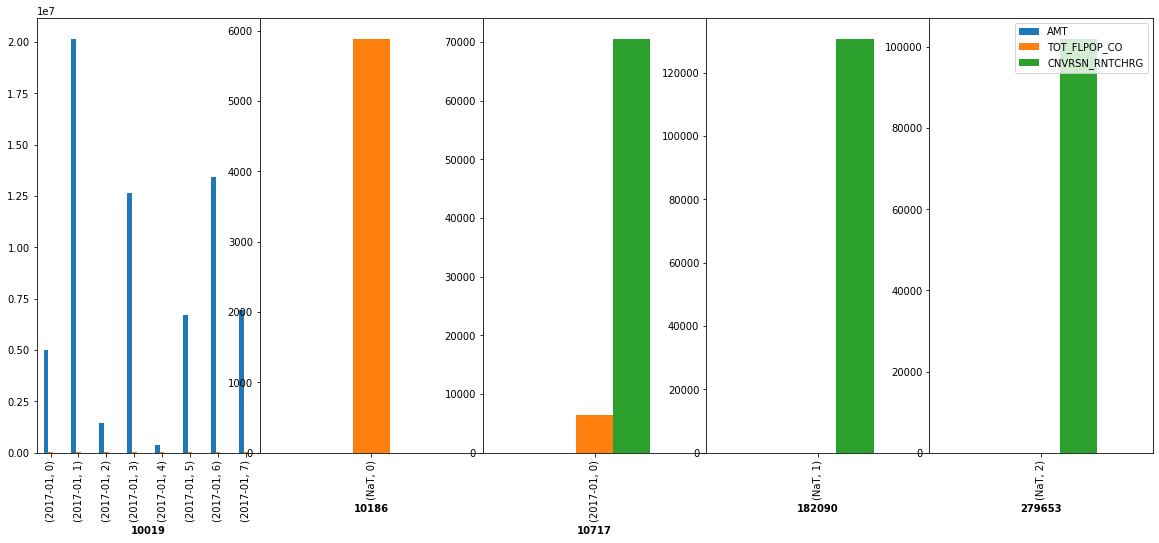

In [713]:
#시계열분석1
columns=['KSIC_CD', 'MCT_CNT', 'CNT', 'MIN_AMT', 'MIN_CNT', 'MAX_AMT',
       'MAX_CNT', 'STDR_YM_CD', 'ML_FLPOP_CO', 'FML_FLPOP_CO',
       'AGRDE_10_FLPOP_CO', 'AGRDE_20_FLPOP_CO', 'AGRDE_30_FLPOP_CO',
       'AGRDE_40_FLPOP_CO', 'AGRDE_50_FLPOP_CO', 'AGRDE_60_ABOVE_FLPOP_CO',
       'TMZON_1_FLPOP_CO', 'TMZON_2_FLPOP_CO', 'TMZON_3_FLPOP_CO',
       'TMZON_4_FLPOP_CO', 'TMZON_5_FLPOP_CO', 'TMZON_6_FLPOP_CO', 'ADSTRD_CD',
       'STDR_YY_CD', 'GTN_AVRG', 'MT_RNTCHRG_AVRG', 'RENT_CO',
        'BLCK_NM'] #연관있는것 제외하고 드랍
data_6.drop(columns, axis=1, inplace=True)

n_subplots = len(data_6.index.levels[0].astype(int))
fig, axes = plt.subplots(nrows=1, ncols=n_subplots, figsize=(20, 8))  # width, height

graph = dict(zip(data_6.index.levels[0].astype(int), axes))
plots=list(map(lambda x: data_6.xs(x).plot(kind='bar', ax=graph[x], legend=False).set_xlabel(x, weight='bold'), graph))
ax.tick_params(axis='both', which='both', length=0)
fig.subplots_adjust(wspace=0)

plt.legend()
plt.show()

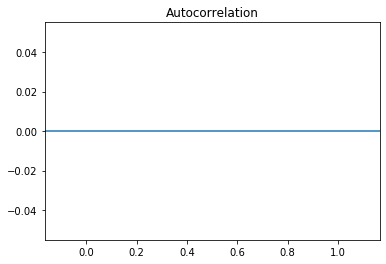

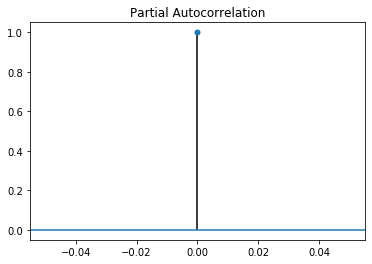

In [714]:
plot_acf(data_6.AMT)
plot_pacf(data_6.AMT)
plt.show()

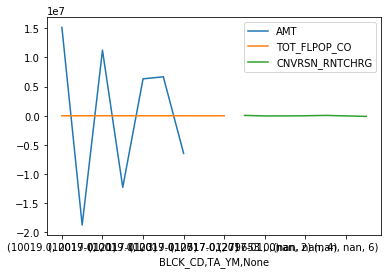

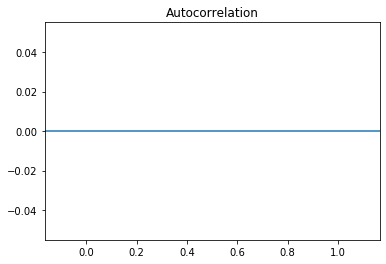

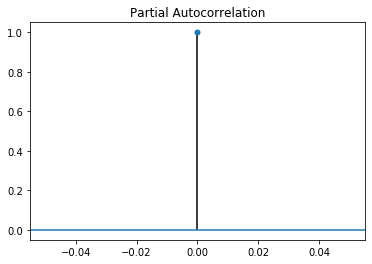

In [715]:
diff_1=data_6.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1.AMT)
plot_pacf(diff_1.AMT)
plt.show()

In [716]:
model = ARIMA(data_6.AMT, order=(0,1,1)) #p,d, q값 설정할것
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: Array must not contain infs or NaNs

In [717]:
model_fit.plot_predict()
#fore=model_fit.forecast(steps=1)
#print(fore)

NameError: name 'model_fit' is not defined

In [731]:
#시계열분석2
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [732]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_6['AMT'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few ob

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:252.32042738055128
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:211.99479913314664


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:216.1914501195998

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:4.0

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:175.27726001137964


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:249.54149100788908


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:207.99225413885637
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:8.0

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:10.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:10.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:208.36221311210653


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:4.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:6.0

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:173.73180627995723


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:6.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:8.0


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:8.0

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:10.0


In [733]:
mod = sm.tsa.statespace.SARIMAX(data_6['AMT'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12), #위의 블럭에서 최저 AIC값인 것 찾기
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0        nan        nan           0           0
ar.S.L12            0         -0        nan        nan           0           0
sigma2         1.0000         -0       -inf      0.000       1.000       1.000


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3053: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\Users\user\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tools\eval_measures.py:370: R

IndexError: index 0 is out of bounds for axis 0 with size 0

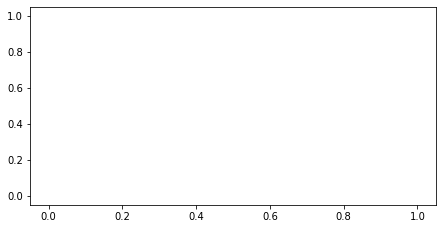

In [734]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [735]:
pred = results.get_prediction(start=pd.to_datetime('2017-01'), dynamic=False)
pred_ci = pred.conf_int() #추정된 계수의 신뢰구간 계산
ax = k['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [736]:
y_forecasted = pred.predicted_mean
y_truth = data_6['AMT']['2017-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

NameError: name 'pred' is not defined